In [162]:
%matplotlib inline
import numpy as np
import pylab as pl
import scipy.special as special
from scipy.integrate import quad
from scipy.integrate import nquad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
#pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'    

In [221]:
#want to plot the integrand in Eq. 60 of the paper
#with filled in values of I(...), delta(yn), 

#constants in natural units
#m = 1.
#c = 1.
theta_e = 10.
theta_e_1 = 10.
#nu_c = 1
#B = 10.
#e = 1


#constants in Gaussian cgs units (values from harmony)
m = 9.1093826e-28
c = 2.99792458e10
e = 4.80320680e-10
B = 30.0
n_e = 1.




#variables to be set (frequency, observer angle, width of delta function, electron number density, 
# sum index n)


theta = np.pi/3.
epsilon = 0.01
n_e = 1
nu_c = e * B / (2. * np.pi * m * c)
nu = 100 * nu_c
nu_s = (2./9.) * nu_c * theta_e**2 * np.sin(theta)
n_e_nt = 1.
#p_PL = 2.2
p_PL = 2.5
gamma_50_min = 1.
gamma_50_max = 1000.
#gamma_50_max = 100.
C = 1.
n_dn = (nu / nu_c) * abs(np.sin(theta))
Index_cutoff = 0.001
kappa = 10.
gamma_cutoff = 1000.

In [222]:
def thermal_dist(gamma):
    frefactor = n_e / (theta_e)
    body = gamma * np.sqrt(gamma**2 - 1.) / (special.kn(2., 1./theta_e))
    tail = np.exp(- gamma / theta_e)
    f = frefactor * body * tail
    return f

#norm_thermal = quad(thermal_dist, 1, np.inf, epsabs = 0, epsrel = 1e-8)[0] 
#print 1./norm_thermal

#A_prim = (1. / norm_thermal) * (n_e / (4. * np.pi * theta_e)) * ( 1. / (special.kn(2., 1./theta_e)))
A_prim = ( n_e / theta_e) * ( 1. / (2. * theta_e**2 - 0.5))




def kappa_dist(gamma):
    frefactor = gamma * np.sqrt(gamma**2 - 1.) * m**3 * c**3
    body = (1 + (gamma - 1.)/(kappa * theta_e_1))**(- kappa - 1.)
    tail = np.exp(- gamma / gamma_cutoff)
    f = frefactor * body * tail
    return f

norm_kappa = quad(kappa_dist, 1, np.inf, epsabs = 0, epsrel = 1e-8)[0]
#print norm_kappa
#norm_kappa = 1.41290009199e-47


A = (1. / (norm_kappa)) * m**3 * c**3

C_low = (2**(4./3.) * np.pi / 3.) * ((n_e * e**2 * nu_s) / (c * theta_e**2)) * (1. / nu_s)**(1. / 3.)

def M_J(x):
    f = C_low * x**(1./3.)
    return f

def kappa_low_freq(x):
#    body = C_low * (A_prim / A) * x**(1. / 3.) * (1 + (gamma - 1.)/(kappa * theta_e))**(- kappa - 1.)
#    tail = np.exp(-gamma/ gamma_cutoff)
#
    body = C_low * (A_prim / A) * x**(1. / 3.)
    f = body
    return f

print A_prim / A


    
def kappa_low_full_gamma(gamma):
    
    f = (1 + (gamma - 1)/(kappa*theta_e))**(-kappa - 1.) * np.exp(-gamma/gamma_cutoff)
    
    return f

norm_kappa_twice = quad(kappa_low_full_gamma, 1., np.inf, epsabs = 0, epsrel = 1e-8)[0]
#print norm_kappa_twice


def kappa_low_freg_true(x):
    f = kappa_low_freq(x) * 1./norm_kappa_twice
    return f
    
    



def power_dist(gamma):
    prefactor = n_e_nt * (p_PL - 1.) / ((gamma_50_min**(1. - p_PL) - gamma_50_max**(1. - p_PL)))
    body = gamma**(- p_PL)
    tail = np.exp(- gamma / gamma_cutoff)
    f = prefactor * body * tail
    return f

norm_power = quad(power_dist, 1., np.inf, epsabs = 0, epsrel = 1e-8)[0]


A_power = (1./norm_power) * n_e_nt*(p_PL - 1.)/(4. * np.pi * (gamma_50_min**(1. - p_PL) - gamma_50_max**(1. - p_PL)))

def C_middle():
    first_part       = n_e_nt * (e**2 * nu_c /c)
    second_part_nume = 3.**(p_PL/2.) * (p_PL - 1.) * np.sin(theta)
    second_part_demo = 2. * (p_PL + 1.) * (gamma_50_min**(1. - p_PL) - gamma_50_max**(1. - p_PL))
    second_part      = second_part_nume/second_part_demo
    third_part       = special.gamma((3. * p_PL - 1.)/ 12.) * special.gamma((3. * p_PL + 19.)/12.)
    forth_part       = (1./(nu_c * np.sin(theta)))**(- (p_PL - 1.)/2.)
    ans              = first_part * second_part * third_part * forth_part
    return ans


def power_law(x):
    f = C_middle() * x**( - (p_PL - 1.)/2);
    return f

def kappa_middle_freg(x):
    f = C_middle() * (A_power / A) * x**(- (p_PL - 1.)/2.)
    return f

#print A_power / A



C_high = n_e * (np.sqrt(2.) * np.pi * e**2 * nu_s / (6. * theta_e**2 * c)) * (1. / nu_s)

def kappa_high_freq(x):
    f = C_high * (A_prim / A) * x * np.exp(- (x / nu_s)**(1./3.))
#    f = C_high * (A_prim / A) * x * np.exp(- x)


    return f



def mix_haha(x):
#1    f = ((kappa_low_freq(x))**(1./2.) + (kappa_middle_freg(x))**(9./24.) + (kappa_high_freq(x))**(1./4.))**4
    f_1 = (1e4*(kappa_low_freq(x))**(1./2.) + (kappa_middle_freg(x))**(9./24.) + (kappa_high_freq(x))**(1./4.))**4
    f = ((kappa_low_freq(x))**(1./2.) + (kappa_middle_freg(x))**(9./24.))**2
#    f = f_1 * np.exp(- ((x / 1e6 * nu_c) - 1 )**(1./10.))
    return f_1


#print C_low, C_high, A_prim / A, nu_s
#print np.pi/2
#print np.pi**13

1.44424940725


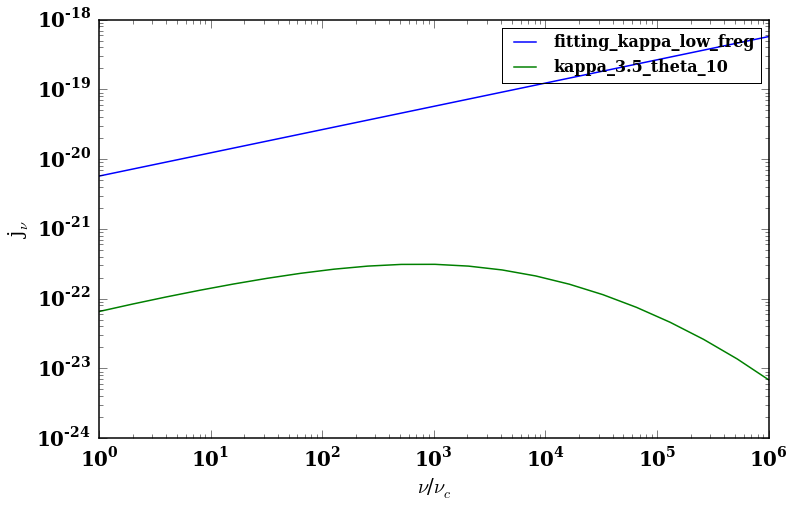

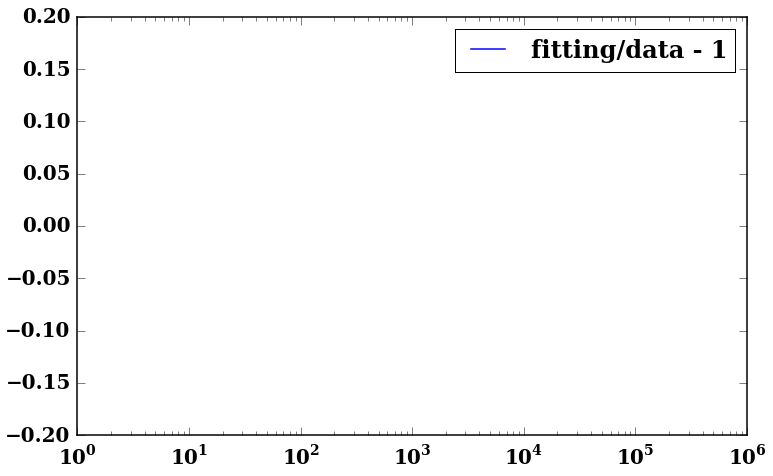

In [192]:
data_kappa_3_5_C_theta_10 = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_10.txt')
data_kappa_3_5_C_theta_100 = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/emi_kappa_3_5_C_theta_100.txt')
data_kappa_150_C_theta_10 = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/emi_kappa_150_C_theta_10.txt')
data_kappa_150_C_theta_100 = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/emi_kappa_150_C_theta_100.txt')

data_thermal_C = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/emi_thermal_C.txt')
data_power_2_5_theta_100 = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/emi_power_2_5_C_theta_100.txt')

data_thermal_python = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/thermal_data_varing_nu.txt')

data_kappa_low_freg_finding_delta = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/kappa_low_freg_finding_delta_vs_kappa.txt')


#data_kappa_150 = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/emi_kappa_150_cut1000_C.txt')


#pl.loglog(data_kappa_150[:,0], data_kappa_150[:, 1], label = 'kappa_150_data')
#pl.loglog(data_kappa_3_5[:,0], data_kappa_3_5[:, 1], label = 'kappa_3.5_data')
#pl.loglog(data_thermal_C[:,0], data_thermal_C[:, 1], label = 'thermal_data_C')
#pl.loglog(data_power_2_5_theta_100[:,0], data_power_2_5_theta_100[:, 1], label = 'power_data')

x = np.arange(0, 1e6, 1)
#pl.loglog(x, M_J(x * nu_c), label = 'M_J_55')

#pl.loglog(x, power_law(x * nu_c), label = 'power_law_58')

#pl.loglog(x, kappa_high_freq(x * nu_c), label = 'fitting_kappa_high_freg')
#l.loglog(data_kappa_3_5_C_theta_100[:,0], data_kappa_3_5_C_theta_100[:, 1], label = 'kappa_3.5_theta_100')

#pl.loglog(data_kappa_150_C_theta_100[:,0], data_kappa_150_C_theta_100[:, 1], label = 'kappa_150_theta_100')
#pl.loglog(data_kappa_150_C_theta_10[:,0], data_kappa_150_C_theta_10[:, 1], label = 'kappa_150_theta_10')
#pl.loglog(data_thermal_python[:,0], data_thermal_python[:, 1], label = 'data_thermal_python')


#pl.semilogy(data_kappa_3_5_C_theta_100[:,0], abs(data_kappa_3_5_C_theta_100[:, 1] * np.pi/2 - kappa_low_freq(data_kappa_3_5_C_theta_100[:,0] * nu_c)), label = 'diff')

def total_fitting(x):
    term1 = kappa_low_freq(x)
    term2 = kappa_middle_freg(x)
    f_mix = 1./(1./term1 + 1./term2)
    f_mix2= np.sqrt(1./((1./term1)**2 + (1./term2)**2))
    f_mix3= (1./((1./term1)**(1./2.) + (1./term2)**(1./2.)))**(2.)
    f_mix4= (1./((1./(1.4 * term1))**(2./3.) + (1./( 1.2 * term2))**(2./3.)))**(3./2.)
    f_mix5= (1./((1./term1)**(4./5.) + (1./term2)**(4./5.)))**(5./4.)
#    f_mix6= (1./((1./(1 * term1))**(2./3.) + (1./( term2))**(2./3.)))**(3./2.)
    return f_mix4


def hahah(x):
    frefactor = C_low
    body = x**(1./3.)
    tail = (1. + 1./kappa)**(-kappa - 1) * np.exp(1)
    f = frefactor * body * tail
    return f

pl.loglog(x, kappa_low_freq(x * nu_c), label = 'fitting_kappa_low_freg')
#pl.loglog(x, kappa_low_freq(x * nu_c), label = 'fitting_kappa_low_freg')
#pl.loglog(x, kappa_middle_freg(x * nu_c)/2, label = 'fitting_kappa_mid_freg')
#pl.loglog(x, kappa_middle_freg(x * nu_c), label = 'fitting_kappa_mid_freg')
pl.loglog(data_kappa_3_5_C_theta_10[:,0], data_kappa_3_5_C_theta_10[:, 1], label = 'kappa_3.5_theta_10')
#pl.loglog(x, total_fitting(x * nu_c), label = 'fitting')
#pl.loglog(x, hahah(x * nu_c), label = 'hahah')
#pl.loglog(x, M_J(x * nu_c), label = 'm_j')

pl.xlim([0, 1e6])
#pl.ylim([1e-28, 1e-14])
pl.xlabel("$\\nu$/$\\nu_c$")
pl.ylabel("j$_\\nu$")
pl.legend(loc = 'upper right', prop= {'size':16})
pl.show()

def error_here_here(x):
    ans = total_fitting(x)/data_kappa_3_5_C_theta_10[:,1] - 1
    return ans

pl.semilogx(data_kappa_3_5_C_theta_10[:,0], error_here_here(data_kappa_3_5_C_theta_10[:,0]*nu_c), label = 'fitting/data - 1')

pl.xlim([0, 1e6])
pl.ylim([-0.2,0.2])
pl.legend()
pl.show()

#print 8. * np.pi**3

1.76872826353e-22


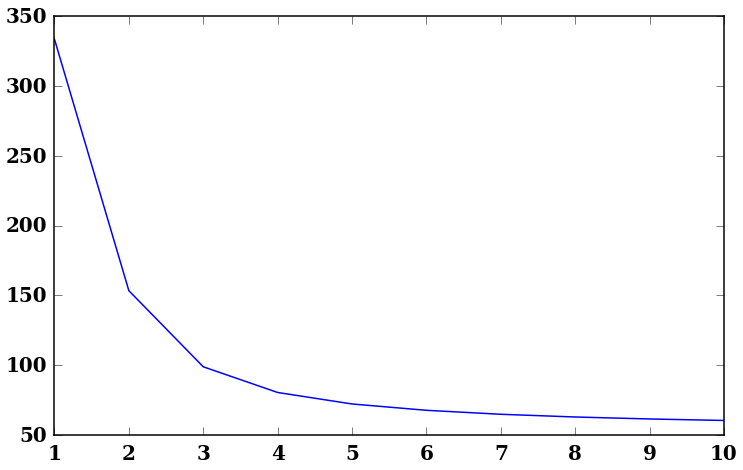

In [225]:
data_kappa_low_freg_finding_delta_fitting = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/kappa_low_freg_finding_delta_vs_kappa_fitting.txt')

data_kappa_low_freg_finding_delta_C = np.loadtxt('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/kappa_low_freg_finding_delta_vs_kappa_C.txt')


print kappa_low_freq(nu_c)

x_here = range(1, 11, 1)

def fuc_here():
    ans = data_kappa_low_freg_finding_delta_fitting/data_kappa_low_freg_finding_delta_C[:,1]
    return ans

pl.plot(x_here, fuc_here())


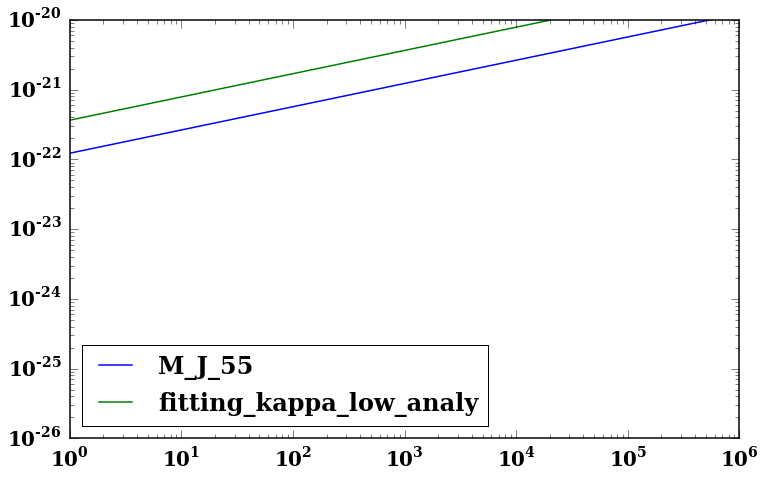

In [22]:
def kappa_low_analy(x):
    prefactor = (2**(4./3.) * np.pi / 3.) * n_e**2 * e**2 * nu_s**(2./3.) / (c * theta_e**3)
    body = 1./(special.kn(2., 1./theta_e) * (1./norm_kappa) * m**3 * c**3)
    f = prefactor * body * x**(1./3.)
    return f

x = np.arange(0, 1e6, 1)
pl.loglog(x, M_J(x * nu_c), label = 'M_J_55')
#pl.loglog(x, kappa_low_freq(x * nu_c), label = 'fitting_kappa_low_freg')
#pl.loglog(x, power_law(x * nu_c), label = 'power_law_58')
#pl.loglog(x, kappa_middle_freg(x * nu_c), label = 'fitting_kappa_mid_freg')
pl.loglog(x, kappa_low_analy(x * nu_c), label = 'fitting_kappa_low_analy')




pl.xlim([0, 1e6])
pl.ylim([1e-26, 1e-20])
pl.legend(loc = 'lower left')
pl.show()




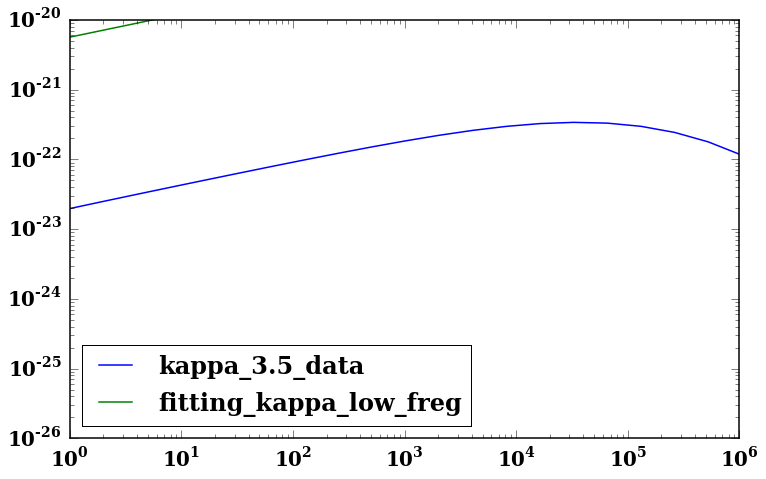

In [23]:
def kappa_mid_analy(x):
    term1 = n_e_nt * e**2 * nu_c / c 
    term2_nume = 3**(p_PL/2) * (p_PL - 1.) * np.sin(theta)
    term2_demo = 2. * (p_PL + 1) * (gamma_50_min**(1. - p_PL) - gamma_50_max**(1. - p_PL))
    term2 = term2_nume/term2_demo
    term3 = special.gamma((3. * p_PL - 1.)/ 12.) * special.gamma((3. * p_PL + 19.)/12.)
    term4 = (1./(nu_c * np.sin(theta)))**(- (p_PL - 1)/2)
    term5_nume = (1./norm_power) * n_e_nt * (p_PL - 1)
    term5_demo = 4. * np.pi * (gamma_50_min**(1. - p_PL) - gamma_50_max**(1. - p_PL))
    term5 = term5_nume / term5_demo
    term6 = 1./((1./norm_kappa) * m**3 * c**3)
    term7 = x**(- (p_PL - 1)/2.)
    f = term1 * term2 * term3 * term4 * term5 * term6 * term7
    return f

x = np.arange(0, 1e6, 1)
#pl.loglog(x, M_J(x * nu_c), label = 'M_J_55')

#pl.loglog(x, power_law(x * nu_c), label = 'power_law_58')
#pl.loglog(x, kappa_middle_freg(x * nu_c), label = 'fitting_kappa_mid_freg')
#pl.loglog(x, kappa_low_analy(x * nu_c), label = 'fitting_kappa_low_analy')
#pl.loglog(x, kappa_mid_analy(x * nu_c) * 8. * np.pi, label = 'fitting_kappa_mid_analy')
#pl.loglog(data_kappa_150[:,0], data_kappa_150[:, 1], label = 'kappa_150_data')
pl.loglog(data_kappa_3_5_C_theta_100[:,0], data_kappa_3_5_C_theta_100[:, 1], label = 'kappa_3.5_data')
pl.loglog(x, kappa_low_freq(x * nu_c) * np.pi * np.pi * np.pi/2, label = 'fitting_kappa_low_freg')
#pl.loglog(x, kappa_low_freg_true(x * nu_c) * np.pi * np.pi * np.pi * 3/4, label = 'new one')

pl.xlim([0, 1e6])
pl.ylim([1e-26, 1e-20])
pl.legend(loc = 'lower left')
pl.show()







In [8]:
nquad?

In [270]:
data_plorization_fraction = np.loadtxt = ('/Users/zhaoweizhang/Documents/synchrotron_calculator_new/polarization_fraction.txt')

#data_result = (data_plorization_fraction[:,1] - data_plorization_fraction[:, 2])/(data_plorization_fraction[:,1] + data_plorization_fraction[:,2])

#print data_result

#print (2.162733e-22 - 4.435173e-23)  /  (4.435173e-23 + 2.162733e-22)
print data_plorization_fraction[:, 0]

TypeError: string indices must be integers, not tuple

In [256]:
print (2.5 + 1) / (2.5 + 7/3)

0.777777777778


In [30]:
for i in range(1, 1000, 10):
    print special.kn(2., 1./i)  - 2. * i**2

-0.375161101365
-0.496625480882
-0.498891349509
-0.499440641335
-0.499659446486
-0.499769418867
-0.499832809333
-0.499872825154
-0.499899777931
-0.499918837522
-0.499932836214
-0.499943434948
-0.499951661786
-0.49995818163
-0.499963440481
-0.499967746829
-0.499971319805
-0.499974318533
-0.499976861036
-0.499979036278
-0.499980912442
-0.499982542548
-0.49998396814
-0.499985222443
-0.499986332157
-0.499987318864
-0.499988200288
-0.49998899104
-0.499989703327
-0.499990347162
-0.499990931305
-0.499991462886
-0.499991948105
-0.499992392317
-0.499992799945
-0.499993175035
-0.499993520963
-0.499993840756
-0.499994136859
-0.499994411948
-0.499994667422
-0.499994905491
-0.499995127728
-0.499995335354
-0.499995529768
-0.499995712074
-0.499995883147
-0.499996044033
-0.499996195431
-0.49999633804
-0.499996472732
-0.499996600091
-0.499996720348
-0.499996834318
-0.499996942235
-0.499997044797
-0.499997142353
-0.499997234554
-0.499997322448
-0.49999740615
-0.499997485895
-0.49999756203
-0.49999763455

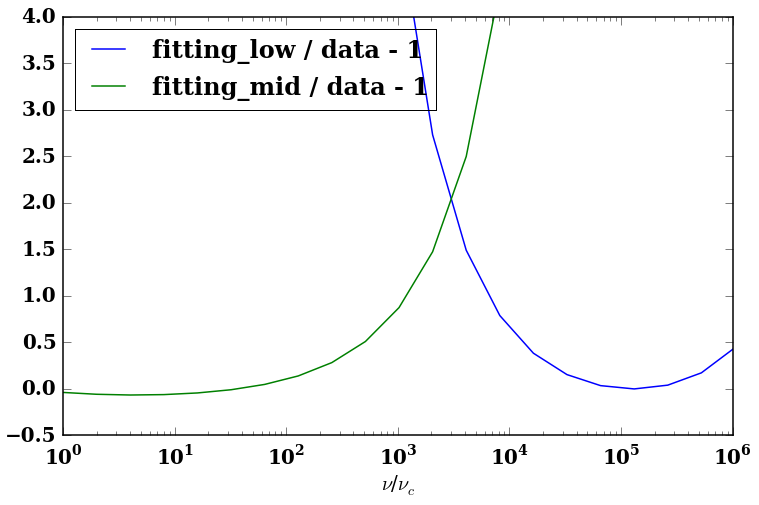

In [33]:
def error_thermal_with_here_low():
    
    data_x = data_kappa_3_5_C_theta_10[:,0]
    
    ans = kappa_low_freq(data_x * nu_c)  /(np.pi**3 /4)
    
    error = ans / data_kappa_3_5_C_theta_10[:, 1] - 1.
    
    return error



def error_thermal_with_here_mid():
    
    data_x = data_kappa_3_5_C_theta_10[:,0]
    
    ans = kappa_middle_freg(data_x * nu_c)/2
    
    error = ans / data_kappa_3_5_C_theta_10[:, 1] - 1.
    
    return error

pl.semilogx(data_kappa_3_5_C_theta_10[:,0], error_thermal_with_here_mid(), label = 'fitting_low / data - 1')
pl.semilogx(data_kappa_3_5_C_theta_10[:,0], error_thermal_with_here_low(), label = 'fitting_mid / data - 1')

pl.xlim([0, 1e6])
pl.ylim([-0.5, 4])
pl.xlabel("$\\nu$/$\\nu_c$")




pl.legend(loc = 'upper left')
pl.show()





In [78]:
def func_test_here(gamma):
    f = np.exp(-gamma/gamma_cutoff)
    return f
print quad(func_test_here, 1, np.inf)[0]


999.000499833


In [154]:
kappa_here = 100
(1. + 1./kappa_here)**(-kappa_here - 1) * np.exp(1)

0.99502898044733423

In [153]:
np.exp(1)

2.7182818284590451